In [1]:
from imutils.video import VideoStream
from imutils import face_utils
import datetime
import argparse
import imutils
import time
import dlib
import cv2
import logging
import json
logging.disable(logging.INFO)

import matplotlib.pyplot as plt
import os
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle

In [2]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# Data Pre-processing

## Data importing

In [2]:
# Initialize dlib's face detector (HOG-based) and then create the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [3]:
# Create prelim df with filename and target emotion class (mood)
data_path = 'dataset/'
model_path = 'trained_models/'
moods = [k for k in os.listdir(data_path) if '.' not in k]

# load vectors & coords df
if os.path.isfile(data_path + 'df_vector_coods.csv'):
    print('Vectors & coords data already exists.')
    df = pd.read_csv(data_path + 'df_vector_coods.csv', index_col='filename')
    df['vectors'] = df['vectors'].apply(json.loads)
    df['coords'] = df['coords'].apply(json.loads)
else:
    data = []
    for mood in moods:
        for filename in os.listdir(data_path + mood):
            data.append([filename, mood])

    df = pd.DataFrame(data, columns=['filename','mood'])
    df.set_index('filename', inplace=True)
    df["vectors"] = [np.array([]) for k in range(df.shape[0])]
    df["coords"] = [np.array([]) for k in range(df.shape[0])]
    
display(df.sample(10))
    
# load graylevels Numpy arrays
if os.path.isfile(data_path + 'graylevels_data.npy'):
    print('Graylevels data already exists.')
    with open(data_path + 'graylevels_data.npy', 'rb') as f:
        cropped_dataset = np.load(f)
        cropped_target = np.load(f)
le = LabelEncoder()
cropped_target = le.fit_transform(cropped_target)

Vectors & coords data already exists.


,mood,vectors,coords
filename,,,
S127_002_00000001.png,neutral,"[-2.4567433430111842, -2.424790672697277, 2.29...","[-0.8257755891878674, -0.3400252426067689, -0...."
S125_002_00000001.png,neutral,"[-2.569069152304439, -2.6078395190628405, 2.56...","[-0.863531226794054, -0.35557168162108105, -0...."
S075_005_00000001.png,neutral,"[-2.6875141304965977, -2.5880990979673966, -0....","[-0.8986656011292992, -0.43863440055120556, -0..."
S109_006_00000015.png,happiness,"[-2.7401142737042608, -2.698104105901733, 2.71...","[-0.9211462162939321, -0.3762428207397751, -0...."
S135_001_00000039.png,surprise,"[-2.257355302182338, -2.135982337800435, -2.07...","[-0.7285345324631733, -0.5203818089022667, -0...."
S075_008_00000001.png,neutral,"[-2.697173443688694, -2.603321210663058, 2.555...","[-0.9028605188239304, -0.42993358039234775, -0..."
S112_005_00000017.png,anger,"[-2.271471983583661, -2.206822762779525, 2.230...","[-0.7591954772626677, -0.3742512916083573, -0...."
S130_013_00000001.png,neutral,"[-2.39008202363143, -2.2953202214198645, -2.33...","[-0.7942494548017852, -0.4321651445245008, -0...."
S138_005_00000001.png,neutral,"[-2.7305062958895205, -2.705834591266049, 2.57...","[-0.918483910172923, -0.35718818728947, -0.892..."


Graylevels data already exists.


In [4]:
# Functions for finding vector magnitude and direction
def mag(pointA, pointB):
    x = pointA[0] - pointB[0]
    y = pointA[1] - pointB[1]
    return math.sqrt(x*x + y*y)

# find angle between two points (-pi to pi rads)
def angle(cog, point):
    x = point[0] - cog[0]
    y = point[1] - cog[1]
    
    if not x:
        return math.pi/2 if y>0 else -math.pi/2
        
    angle = math.atan(y/x)
    if x<0 and y>0: # 2nd quadrant
        angle += math.pi
    elif x<0 and y<0: # 3rd quadrant
        angle -= math.pi
    return angle

## Feature Extraction - Vectors

The cell below takes awhile.

anger
S010_004_00000019.png


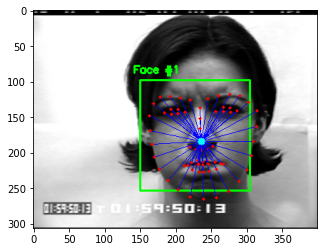

contempt
S138_008_00000009.png


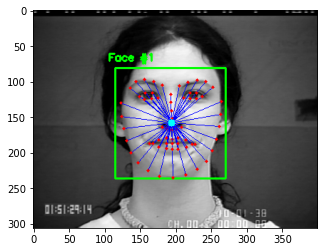

disgust
S005_001_00000011.png


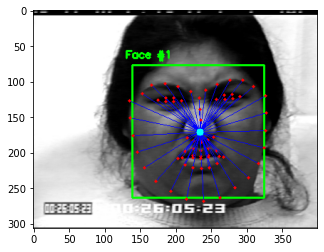

fear
S011_003_00000014.png


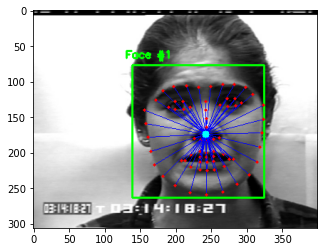

happiness
S010_006_00000015.png


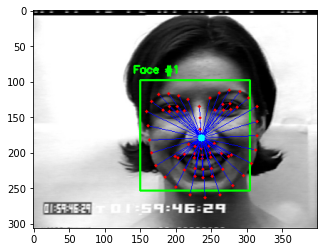

neutral
S005_001_00000001.png


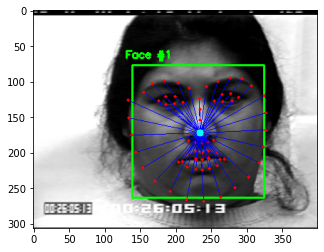

sadness
S011_002_00000022.png


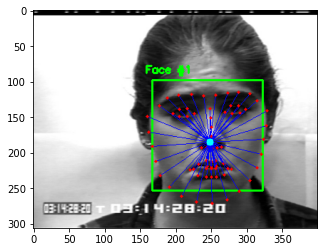

surprise
S010_002_00000014.png


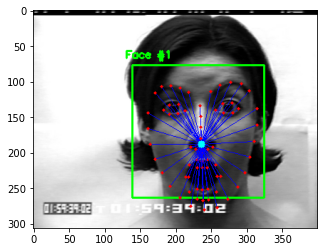

In [6]:
# Populate df with (reshaped) vector data
features = {}
for mood in moods:
    features[mood] = []
    print(mood)
    show = True # show only the first image of each emotion
    for filename in os.listdir(data_path + mood):
        path = data_path + mood + '/' + filename
        vectors = [] # list of vectors
        coords = [] # list of coordinates of facial landmarks (offset by cog)
        
        # load the input image, resize it, and convert it to grayscale
        image = cv2.imread(path)
        image = imutils.resize(image, width=400)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.equalizeHist(gray)

        # detect faces in the grayscale image
        rects = detector(gray, 1)

        # loop over the face detections (multiple faces)
        for (i, rect) in enumerate(rects):
            shape = predictor(gray, rect) # determine facial landmarks for face region
            shape = face_utils.shape_to_np(shape) # convert the facial landmark (x,y)-coordinates to a Numpy array

            if show:
                (x,y,w,h) = face_utils.rect_to_bb(rect) # convert dlib's rectangle to a OpenCV-style bounding box [i.e., (x,y,w,h)]
                cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2) # draw the face bounding box
                cv2.putText(image, "Face #{}".format(i+1), (x-10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2) # show face number
            
            cog = tuple(shape.mean(axis=0).astype(int)) # get center of gravity (COG)

            # draw (x,y)-coordinates for the facial landmarks on image
            for (x,y) in shape:
                if show:
                    cv2.line(image, (x,y), cog, (0,0,255), 1) # draw vector lines
                    cv2.circle(image, (x,y), 2, (255,0,0), -1) # image, center-coords, radius, colour, thickness(fill)
                vectors.append([mag(cog, (x,y)), angle(cog, (x,y))]) # get vector magnitude and direction
                coords.append([x-cog[0], y-cog[1]]) # append coordinates relative to cog
            if show:
                cv2.circle(image, cog, 5, (0,255,255), -1)

        # show the output image with the face detections + facial landmarks
        if show:
            print(filename)
            plt.imshow(image) # adapted for jupyter
            plt.show()
        
        # store inputs in dataset
        vectors = np.array(vectors)
        scale_factor = 1 / max(vectors[:,0])
        vectors[:,0] = vectors[:,0] * scale_factor # normalize magnitudes
        vectors = vectors[:,0] * vectors[:,1]
        df.loc[filename, 'vectors'] = vectors
    
        coords = np.array(coords) * scale_factor
        coords = coords.reshape(-1)
        df.loc[filename, 'coords'] = coords
        
        show = False

In [7]:
df.sample(5)

,mood,vectors,coords
filename,,,
S099_004_00000001.png,neutral,"[-2.6576432657297686, -2.503254205720857, -0.0...","[-0.8851642649348079, -0.46527865208111696, -0..."
S125_007_00000009.png,surprise,"[-2.3672153606431108, -2.3720749957078584, 2.3...","[-0.7906442254257819, -0.39532211271289097, -0..."
S079_002_00000001.png,neutral,"[-2.4449696138027033, -2.387207609984967, -2.3...","[-0.8127425537743156, -0.4402355499610876, -0...."
S504_004_00000001.png,neutral,"[-2.5149890615323023, -2.54237922637585, 2.520...","[-0.8439670024954015, -0.3739094314853044, -0...."
S060_005_00000021.png,disgust,"[-2.646040980103964, -2.5479972911967055, -2.5...","[-0.879706513576127, -0.47551703436547405, -0...."


In [8]:
# Save df with vectors and coords to CSV
df['vectors'] = df['vectors'].apply(lambda x:list(x)).apply(json.dumps)
df['coords'] = df['coords'].apply(lambda x:list(x)).apply(json.dumps)
df.to_csv(data_path + 'df_vector_coods.csv')

## Feature extraction - Cropped Faces

In [24]:
# RUN THIS
dim = 50

anger
S010_004_00000019.png


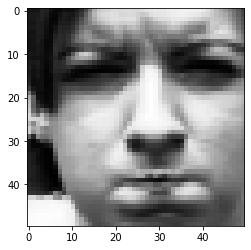

contempt
S138_008_00000009.png


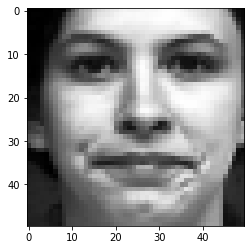

disgust
S005_001_00000011.png


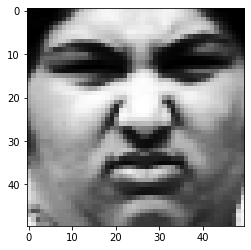

fear
S011_003_00000014.png


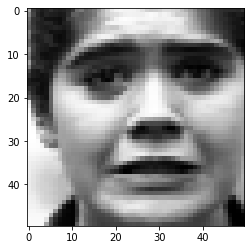

happiness
S010_006_00000015.png


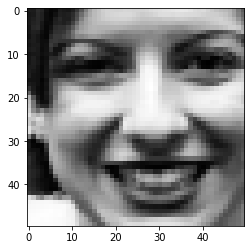

neutral
S005_001_00000001.png


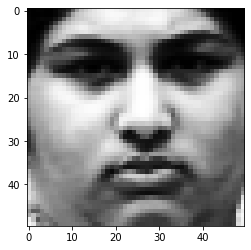

sadness
S011_002_00000022.png


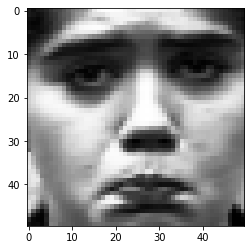

surprise
S010_002_00000014.png


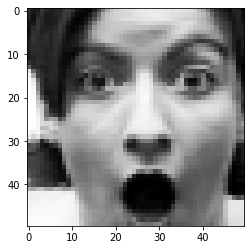

In [10]:
cropped_dataset, cropped_target = [], [] # dataset.shape=(num_datapoints, 100, 100)
for mood in moods:
    print(mood)
    show = True # show only the first image of each emotion
    for filename in os.listdir(data_path + mood):
        path = data_path + mood + '/' + filename
        
        # load the input image, resize it, and convert it to grayscale
        image = cv2.imread(path)
        image = imutils.resize(image, width=400)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # detect faces in the grayscale image
        rects = detector(gray, 1)

        # loop over the face detections (multiple faces)
        for (i, rect) in enumerate(rects):
            # determine the facial landmarks for the face region, then
            # convert the facial landmark (x,y)-coordinates to a NumPy array
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape) 

            # convert dlib's rectangle to a OpenCV-style bounding box
            # [i.e., (x, y, w, h)], then draw the face bounding box
            (x,y,w,h) = face_utils.rect_to_bb(rect)
            cropped_image = image[y:y+h, x:x+w]
            cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)
            cropped_image = cv2.equalizeHist(cropped_image)
                
        # resize and square-crop cropped face
        cropped_image = imutils.resize(cropped_image, width=int(dim*1.05)) # buffer for cropping
        cropped_image = cropped_image[:dim,:dim]
        if cropped_image.shape[0]!=dim or cropped_image.shape[1]!=dim:
            print(cropped_image.shape)
            
        # add to dataset
        cropped_dataset.append(cropped_image)
        cropped_target.append(mood)
        
        # show the output image with the face detections + facial landmarks
        if show:
            print(filename)
            plt.imshow(cropped_image, cmap='gray') # adapted for jupyter
            plt.show()
        
        show = False

cropped_dataset = np.array(cropped_dataset)
cropped_target = np.array(cropped_target)

In [11]:
# Save image graylevels arrays
with open(data_path + 'graylevels_data.npy', 'wb') as f:
    np.save(f, cropped_dataset)
    np.save(f, cropped_target)

# Model training

In [5]:
from keras.layers import Dense, Input, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.layers import GlobalAveragePooling1D, Conv1D, MaxPooling1D
from keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score

## Functions
The following functions are used for building, training and evaluation of CNN models for inputs of vectors, coordinates and image graylevels.

In [6]:
num_classes = len(moods)

def build_cnn(model_name, model_num, input_shape):
    print('Building model...', end=' ')
    model = Sequential()

    # CS3237 model for coords & vectors
    if model_num == 1:
        model.add(Conv1D(32, kernel_size=5, activation='relu', input_shape=input_shape, padding='same'))
        model.add(MaxPooling1D(pool_size=2, strides=2))
        model.add(Conv1D(64, kernel_size=5, activation='relu'))
        model.add(Conv1D(128, kernel_size=5, activation='relu'))
        model.add(Conv1D(64, kernel_size=5, activation='relu'))
        model.add(MaxPooling1D(pool_size=2, strides=2))
        model.add(Flatten())
        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(0.1))

    # Ansamma's model
    if model_num == 2:
        model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape, padding='same'))
        model.add(MaxPooling1D(pool_size=2, strides=2))
        model.add(Conv1D(128, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2, strides=2))
        model.add(Conv1D(512, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2, strides=2))
        model.add(Conv1D(512, kernel_size=3, activation='relu'))
        model.add(MaxPooling1D(pool_size=2, strides=2))
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.1))

    # CS3237 model for image graylevels
    if model_num == 3:
        model.add(Conv2D(32, kernel_size=(5,5), activation='relu', input_shape=input_shape, padding='same'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=2))
        model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
        model.add(Conv2D(128, kernel_size=(5,5), activation='relu'))
        model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=2))
        model.add(Flatten())
        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(0.1))

    model.add(Dense(num_classes, activation='softmax'))

    print('Model built.')
    
    return model

In [7]:
def train_cnn(model, data, epochs, model_name, verbose=False, plots=True):
    
    x_train, y_train, x_val, y_val, x_test, y_test = data[0], data[1], data[2], data[3], data[4], data[5]
    opt = Adam(learning_rate = 0.0001)
#     opt = SGD(learning_rate=0.01, momentum=0.7)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    savemodel = ModelCheckpoint(model_name)
    stopmodel = EarlyStopping(min_delta=0.001, patience=10)

    print("Starting training...")
    start = time.time()
    history = model.fit(x=x_train, y=y_train, batch_size=64,
              validation_data=(x_val,y_val), shuffle=True,
              epochs=epochs, verbose=verbose,
              callbacks=[savemodel,stopmodel])
    end = time.time()
    tt = end - start
    print("Done (%d epochs). Time taken: %dm%ds." % (len(history.history['loss']), tt//60, tt%60))
    
    if plots:
        # plot loss
        plt.title('Cross Entropy Loss')
        plt.plot(history.history['loss'], color='blue', label='train')
        plt.plot(history.history['val_loss'], color='orange', label='validation')
        ymax = max([1, max(history.history['loss'])+0.05, max(history.history['val_loss'])+0.05])
        plt.ylim(0,ymax)
        plt.legend()
        plt.show()

        # plot accuracy
        plt.title('Classification Accuracy')
        plt.plot(history.history['accuracy'], color='blue', label='train')
        plt.plot(history.history['val_accuracy'], color='orange', label='validation')
        plt.ylim(0,1)
        plt.legend()
        plt.show()

In [8]:
def evaluate_cnn(model_name, data):
    model = load_model(model_name)
    x_train, y_train, x_val, y_val, x_test, y_test = data[0], data[1], data[2], data[3], data[4], data[5]
    loss_tr, acc_tr = model.evaluate(x=x_train, y=y_train, verbose=False)
    loss_val, acc_val = model.evaluate(x=x_val, y=y_val, verbose=False)
    loss_ts, acc_ts = model.evaluate(x=x_test, y=y_test, verbose=False)
    print('Train accuracy: %.4f, loss: %.4f' % (acc_tr, loss_tr))
    print('Validation accuracy: %.4f, loss: %.4f' % (acc_val, loss_val))
    print("Test accuracy: %4.3f, loss: %4.3f"%(acc_ts, loss_ts))
    return (acc_tr, acc_val, acc_ts)

## CNN
CNN models trained on vectors and coordinates.

### CNN Datasets
Separate datasets ```cnn_vectors_only_data``` and ```cnn_vectors_coords_data``` for dataset with vectors only and dataset with both vectors and coordinates.

In [9]:
# One hot encoding for emotion
cnn_data = pd.get_dummies(df.mood).join(df.loc[:,['vectors','coords']])
emotion_classes = cnn_data.columns[:len(moods)]
print('One hot encoded:')
display(cnn_data.sample(5))

One hot encoded:


,anger,contempt,disgust,fear,happiness,neutral,sadness,surprise,vectors,coords
filename,,,,,,,,,,
S089_002_00000021.png,0,0,0,0,1,0,0,0,"[-2.310324092788345, -2.2442379376289243, 2.24...","[-0.7733164944356038, -0.36881248196159566, -0..."
S058_001_00000001.png,0,0,0,0,0,1,0,0,"[-2.668236611754878, -2.5568845239713935, -0.0...","[-0.8900433648586652, -0.4558758698056578, -0...."
S119_005_00000001.png,0,0,0,0,0,1,0,0,"[-2.8102299472418424, -2.7632490787956168, 2.6...","[-0.9455831622752826, -0.3238298500942749, -0...."
S138_007_00000001.png,0,0,0,0,0,1,0,0,"[-2.6866355463603906, -2.6681419669641846, 2.5...","[-0.9038903850583723, -0.34373296333205705, -0..."
S130_002_00000001.png,0,0,0,0,0,1,0,0,"[-2.3883999835371568, -2.3050487689646837, -2....","[-0.7869822187256901, -0.47450398481990136, -0..."


In [10]:
# Dataset for vectors only
# split into train, val and test
x = np.array([k for k in cnn_data['vectors'].values])
y = cnn_data.iloc[:,:8].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=0)

# reshape for CNN
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

cnn_vectors_only_data = [x_train, y_train, x_val, y_val, x_test, y_test]

print('(Vectors Only) Train X shape:', x_train.shape)
print('(Vectors Only) Train Y shape:', y_train.shape)

(Vectors Only) Train X shape: (588, 68, 1)
(Vectors Only) Train Y shape: (588, 8)


In [11]:
# Dataset for vectors & coords
# split into train, val and test
x = np.c_[np.array([k for k in cnn_data['vectors'].values]), np.array([k for k in cnn_data['coords'].values])]
y = cnn_data.iloc[:,:8].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=0)

# reshape for CNN
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

cnn_vectors_coords_data = [x_train, y_train, x_val, y_val, x_test, y_test]

print('(Vectors & Coords) Train X shape:', x_train.shape)
print('(Vectors & Coords) Train Y shape:', y_train.shape)

(Vectors & Coords) Train X shape: (588, 204, 1)
(Vectors & Coords) Train Y shape: (588, 8)


### CNN Models

Building model... Model built.
Starting training...
Done (162 epochs). Time taken: 323.452s.


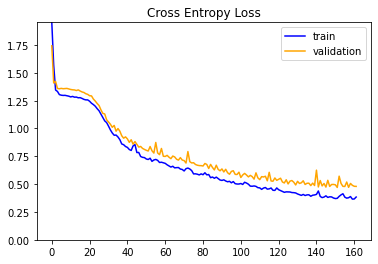

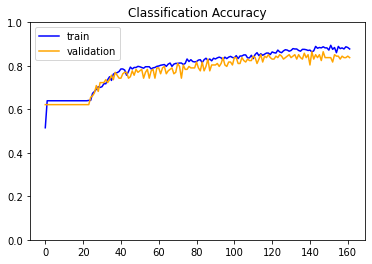

Train accuracy: 0.8946, loss: 0.3444
Validation accuracy: 0.8378, loss: 0.4798
Test accuracy: 0.859, loss: 0.570


In [27]:
# CNN1: CS3237 model (Vectors only)
MODEL_NAME = model_path + 'emotion-cnn1.hd5'
model = build_cnn(MODEL_NAME, 1, (cnn_vectors_only_data[0].shape[1],1))
train_cnn(model, cnn_vectors_only_data, 200, MODEL_NAME)
cnn1_acc = evaluate_cnn(MODEL_NAME, cnn_vectors_only_data)

Building model... Model built.
Starting training...
Done (107 epochs). Time taken: 268.955s.


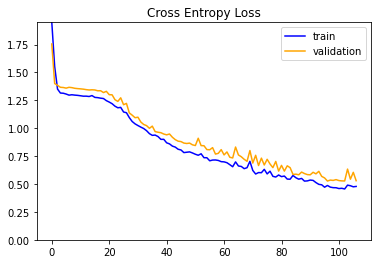

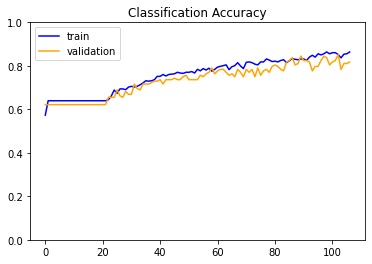

Train accuracy: 0.8690, loss: 0.4292
Validation accuracy: 0.8176, loss: 0.5295
Test accuracy: 0.837, loss: 0.590


In [28]:
# CNN2: Ansamma's model (Vectors only)
MODEL_NAME = model_path + 'emotion-cnn2.hd5'
model = build_cnn(MODEL_NAME, 2, (68,1))
train_cnn(model, cnn_vectors_only_data, 200, MODEL_NAME)
cnn2_acc = evaluate_cnn(MODEL_NAME, cnn_vectors_only_data)

Building model... Model built.
Starting training...
Done (126 epochs). Time taken: 5m56s.


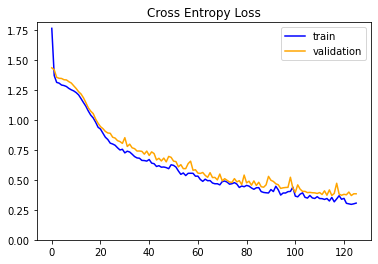

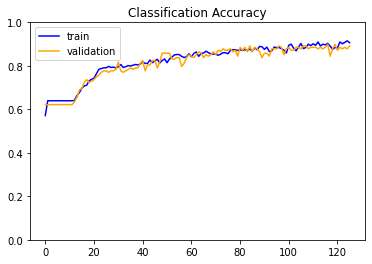

Train accuracy: 0.9048, loss: 0.2951
Validation accuracy: 0.8919, loss: 0.3847
Test accuracy: 0.853, loss: 0.528


In [12]:
# CNN3: CS3237 model (Vectors & coords)
MODEL_NAME = model_path + 'emotion-cnn3.hd5'
model = build_cnn(MODEL_NAME, 1, (cnn_vectors_coords_data[0].shape[1],1))
train_cnn(model, cnn_vectors_coords_data, 200, MODEL_NAME)
cnn3_acc = evaluate_cnn(MODEL_NAME, cnn_vectors_coords_data)

## SVM

### SVM Datasets
Separate datasets ```svm_vectors_only_data``` and ```svm_vectors_coords_data``` for dataset with vectors only and dataset with both vectors and coordinates.

In [13]:
# Label encoding for SVM
svm_data = df.copy()
le = LabelEncoder()
svm_data['mood'] = le.fit_transform(svm_data['mood'].values)
svm_classes = list(le.inverse_transform(np.arange(0,8)))
print('Label encoded:')
display(svm_data.sample(5))

Label encoded:


,mood,vectors,coords
filename,,,
S064_001_00000012.png,7,"[-2.4696766677846607, -2.374955291897143, -2.3...","[-0.8191489361702128, -0.4574468085106383, -0...."
S050_001_00000017.png,3,"[-2.4805310509515945, -2.447185871491196, 2.30...","[-0.8344541683690267, -0.3220700298968173, -0...."
S506_006_00000042.png,6,"[-2.6015141369533756, -0.0, 2.424619064387329,...","[-0.8715628933760665, -0.2207959329886035, -0...."
S061_004_00000022.png,2,"[-2.7109001422032852, -2.6944912986881215, 2.6...","[-0.9086768439633127, -0.41750017155071123, -0..."
S116_004_00000001.png,5,"[-2.523605927639074, -2.437024908040294, -2.46...","[-0.8323141916249217, -0.49690399499995325, -0..."


In [14]:
# Dataset for vectors only
# split into train, val and test
x = np.array([k for k in svm_data['vectors'].values])
y = svm_data['mood'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

svm_vectors_only_data = [x_train, y_train, x_test, y_test]

print('(Vectors only) Train X shape:', x_train.shape)
print('(Vectors only) Train Y shape:', y_train.shape)

(Vectors only) Train X shape: (736, 68)
(Vectors only) Train Y shape: (736,)


In [15]:
# Dataset for vectors & coords
# split into train, val and test
x = np.c_[np.array([k for k in svm_data['vectors'].values]), np.array([k for k in svm_data['coords'].values])]
y = svm_data['mood'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=0)

svm_vectors_coords_data = [x_train, y_train, x_test, y_test]

print('(Vectors & Coords) Train X shape:', x_train.shape)
print('(Vectors & Coords) Train Y shape:', y_train.shape)

(Vectors & Coords) Train X shape: (736, 204)
(Vectors & Coords) Train Y shape: (736,)


### SVM Functions
Functions for building, training and evaluation of SVM models.

In [16]:
def train_svm(x_train, y_train):
    params = {'C':[10e-3, 10e-2, 0.1, 1, 10], 'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'decision_function_shape':('ovr', 'ovo')}
    svm_pipe = Pipeline([('scaler', StandardScaler()), 
                       ('svm', GridSearchCV(svm.SVC(max_iter=100000, probability=True), params)), ])
    start = time.time()
    svm_pipe.fit(x_train, y_train)
    end = time.time()
    print('SVM model trained. Time taken: %.3fs.' % (end-start))
    print('Best params:', svm_pipe['svm'].best_params_)
    
    return svm_pipe

In [17]:
def evaluate_svm(svm, data, name):
    x_train, y_train, x_test, y_test = data[0], data[1], data[2], data[3]
    
    # Prediction
    y_train_pred = svm.predict(x_train)
    y_test_pred = svm.predict(x_test)

    # Evaluation
    acc_tr = accuracy_score(y_train, y_train_pred)
    acc_ts = accuracy_score(y_test, y_test_pred)
    print('%s Train accuracy: %.4f' % (name, acc_tr))
    print('%s Test accuracy: %.4f' % (name, acc_ts))
    
    return (acc_tr, None, acc_ts)

### SVM1: Vectors only

In [18]:
svm1 = train_svm(svm_vectors_only_data[0], svm_vectors_only_data[1])

SVM model trained. Time taken: 30.527s.
Best params: {'C': 1, 'decision_function_shape': 'ovr', 'kernel': 'linear'}


In [19]:
svm1_acc = evaluate_svm(svm1, svm_vectors_only_data, 'SVM1')

SVM1 Train accuracy: 0.9932
SVM1 Test accuracy: 0.8750


### SVM2: Vectors & Coords

In [20]:
svm2 = train_svm(svm_vectors_coords_data[0], svm_vectors_coords_data[1])

SVM model trained. Time taken: 52.632s.
Best params: {'C': 0.1, 'decision_function_shape': 'ovr', 'kernel': 'linear'}


In [21]:
svm2_acc = evaluate_svm(svm2, svm_vectors_coords_data, 'SVM2')

SVM2 Train accuracy: 0.9891
SVM2 Test accuracy: 0.9022


In [22]:
# Save models
pickle.dump(svm1, open(model_path + 'emotion-svm1', 'wb'))
pickle.dump(svm2, open(model_path + 'emotion-svm2', 'wb'))

## Cropped Images
Model input is pixel graylevels instead of vectors/coordinates. CNN is used.

In [25]:
# train-test-val split
x_train, x_test, y_train, y_test = train_test_split(cropped_dataset, cropped_target, test_size=0.20, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=0)

# reshape for CNN (samples, w, h, c)
x_train = x_train.reshape(x_train.shape[0], dim, dim, 1)
x_val = x_val.reshape(x_val.shape[0], dim, dim, 1)
x_test = x_test.reshape(x_test.shape[0], dim, dim, 1)

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

# normalization
x_train /= 255.0
x_val /= 255.0
x_test /= 255.0

# one-hot encoding
num_classes = len(moods)
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes) 

graylevels_data = [x_train, y_train, x_val, y_val, x_test, y_test]

print('Train X shape:', x_train.shape)
print('Train Y shape:', y_train.shape)

Train X shape: (588, 50, 50, 1)
Train Y shape: (588, 8)


Building model... Model built.
Starting training...
Done (52 epochs). Time taken: 1m3s.


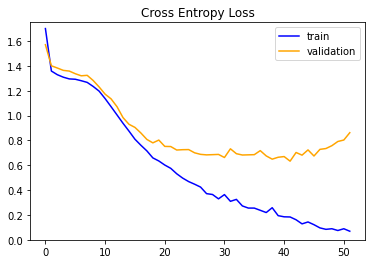

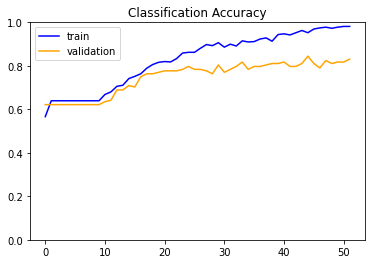

Train accuracy: 0.9745, loss: 0.0720
Validation accuracy: 0.8311, loss: 0.8620
Test accuracy: 0.821, loss: 0.857


In [26]:
MODEL_NAME = model_path + 'emotion-cnnA.hd5'
model = build_cnn(MODEL_NAME, 3, (dim, dim, 1))
train_cnn(model, graylevels_data, 100, MODEL_NAME, verbose=False)
cnnA_acc = evaluate_cnn(MODEL_NAME, graylevels_data)

# Comparison
This section is for comparison between models. I'll compare their accuracies, then I'll test the models on random images.

## Metrics

In [42]:
accuracies = [cnn1_acc, cnn2_acc, cnn3_acc, svm1_acc, svm2_acc, cnnA_acc]
evaluate_dict = {
    'Model': ['CNN1','CNN2','CNN3','SVM1','SVM2','CNNA'],
    'Inputs': ['Vectors only','Vectors only','Vectors & coords','Vectors only','Vectors & coords','Pixel graylevels'],
    'Train acc': [k[0] for k in accuracies],
    'Val acc': [k[1] for k in accuracies],
    'Test acc': [k[2] for k in accuracies]
}
evaluate_df = pd.DataFrame(evaluate_dict)
evaluate_df.set_index('Model', inplace=True)
display(evaluate_df)

,Inputs,Train acc,Val acc,Test acc
Model,,,,
CNN1,Vectors only,0.894558,0.837838,0.858696
CNN2,Vectors only,0.869048,0.817568,0.836957
CNN3,Vectors & coords,0.916667,0.898649,0.858696
SVM1,Vectors only,0.993207,NaN,0.875000
SVM2,Vectors & coords,0.989130,NaN,0.902174
CNNA,Pixel graylevels,0.950680,0.831081,0.842391


## Testing Models

dataset/neutral/S105_002_00000001.png


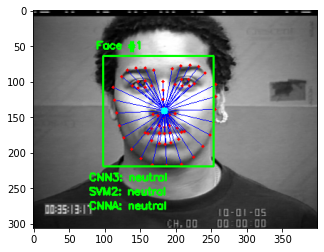

dataset/neutral/S126_008_00000001.png


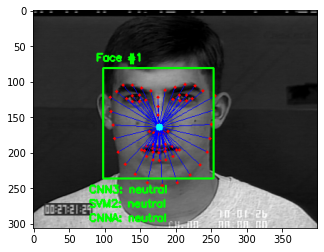

dataset/disgust/S107_005_00000011.png


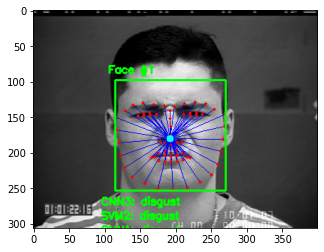

dataset/contempt/S503_002_00000008.png


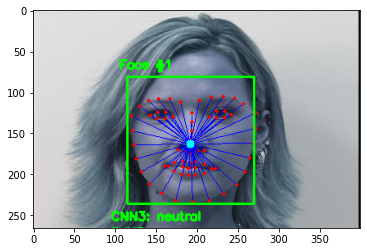

dataset/disgust/S098_003_00000013.png


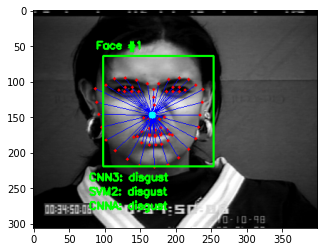

dataset/neutral/S106_003_00000001.png


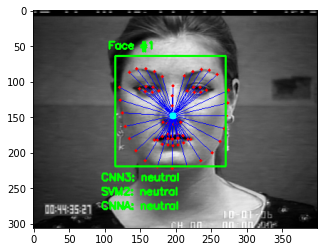

dataset/surprise/S117_001_00000014.png


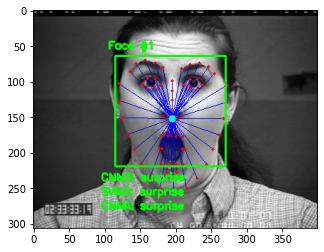

dataset/neutral/S091_002_00000001.png


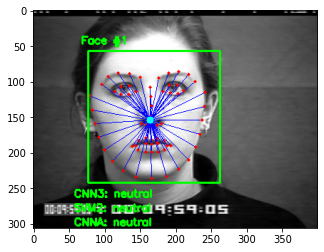

dataset/neutral/S118_005_00000001.png


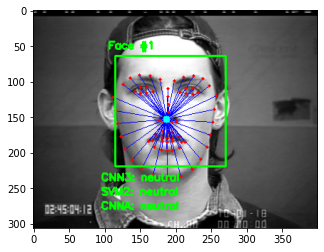

dataset/neutral/S042_003_00000001.png


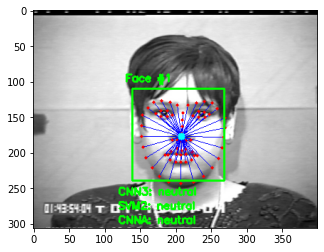

In [43]:
import random

# get all image filenames
image_filenames = []
for root, dirs, files in os.walk(data_path):
    dir = os.path.basename(root)
    for file in files:
        image_filenames += [data_path + dir + '/' + file]
        
rand_images = random.sample(image_filenames, 10) # get random images

# load models
cnn1 = load_model(model_path+'emotion-cnn1.hd5')
cnn3 = load_model(model_path+'emotion-cnn3.hd5')
svm1 = pickle.load(open(model_path+'emotion-svm1', 'rb'))
svm2 = pickle.load(open(model_path+'emotion-svm2', 'rb')) 
cnnA = load_model(model_path+'emotion-cnnA.hd5')

for path in rand_images:
    vectors, coords = [], []
    classes = {}
    
    image = cv2.imread(path)
    image = imutils.resize(image, width=400)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    rects = detector(gray, 1)

    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape) 

        cog = tuple(shape.mean(axis=0).astype(int)) # get center of gravity (COG)

        for (x,y) in shape:
            cv2.line(image, (x,y), cog, (0,0,255), 1) # draw vector lines
            cv2.circle(image, (x,y), 2, (255,0,0), -1) # image, center-coords, radius, colour, thickness(fill)
            vectors.append([mag(cog, (x,y)), angle(cog, (x,y))]) # get vector magnitude and direction
            coords.append([x-cog[0], y-cog[1]])

        cv2.circle(image, cog, 5, (0,255,255), -1)
        
        (x,y,w,h) = face_utils.rect_to_bb(rect)
        cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(image, "Face #{}".format(i+1), (x-10, y-10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
        
        # model inputs
        ## vectors & coords
        vectors = np.array(vectors)
        scale_factor = 1 / max(vectors[:,0])
        vectors[:,0] = vectors[:,0] * scale_factor # normalize magnitudes
        vectors = vectors[:,0] * vectors[:,1]
        coords = (np.array(coords) * scale_factor).reshape(-1) # 1D array
        
        svm1_input = vectors.reshape(1,-1)
        cnn1_input = vectors.reshape(1, len(vectors), 1)
        svm2_input = np.r_[vectors, coords].reshape(1,-1)
        cnn3_input = np.r_[vectors, coords].reshape(1, len(vectors)+len(coords), 1)
#         print(svm_input.shape, cnn_input.shape)
        
        ## image graylevels
        cnnA_input = image[y:y+h, x:x+w] # crop to face
        cnnA_input = cv2.cvtColor(cnnA_input, cv2.COLOR_RGB2GRAY) # convert to grayscale
        cnnA_input = cv2.equalizeHist(cnnA_input) # equalize histogram
        cnnA_input = imutils.resize(cnnA_input, width=int(dim*1.05)) # buffer of 5 pixels for cropping to 100x100
        cnnA_input = np.expand_dims(cnnA_input[:dim,:dim], axis=0) # shape=(1,dim,dim)
    
        # prediction
        classes['CNN3'] = emotion_classes[np.argmax(cnn3.predict(cnn3_input))]
        classes['SVM2'] = emotion_classes[svm2.predict(svm2_input)[0]]
        classes['CNNA'] = emotion_classes[np.argmax(cnnA.predict(cnnA_input))]
        i = 1
        for k,v in classes.items():
            cv2.putText(image, '%s: %s' % (k,v), (x-20,y+h+20*i),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
            i += 1
    
    print(path)
    plt.imshow(image) # adapted for jupyter
    plt.show()

## Just in case

In [44]:
        # Akmadan's model
#         #1st CNN layer
#         model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(MaxPooling2D(pool_size = (2,2)))
#         model.add(Dropout(0.25))

#         #2nd CNN layer
#         model.add(Conv2D(128,(5,5),padding = 'same'))
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(MaxPooling2D(pool_size = (2,2)))
#         model.add(Dropout (0.25))

#         #3rd CNN layer
#         model.add(Conv2D(512,(3,3),padding = 'same'))
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(MaxPooling2D(pool_size = (2,2)))
#         model.add(Dropout (0.25))

#         #4th CNN layer
#         model.add(Conv2D(512,(3,3), padding='same'))
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(MaxPooling2D(pool_size=(2, 2)))
#         model.add(Dropout(0.25))

#         model.add(Flatten())

#         #Fully connected 1st layer
#         model.add(Dense(256))
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(Dropout(0.25))

#         # Fully connected layer 2nd layer
#         model.add(Dense(512))
#         model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(Dropout(0.25))